# House Pricing Homework

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from functions import *
style.use("seaborn")

In [2]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# EDA

In [3]:
df.median_house_value.describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

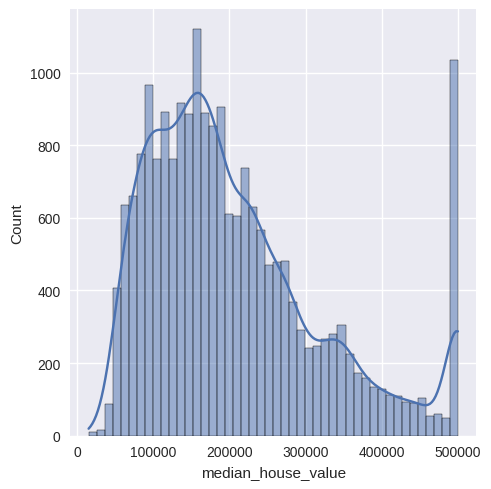

In [4]:
sns.displot(x='median_house_value',kde=True,data=df)

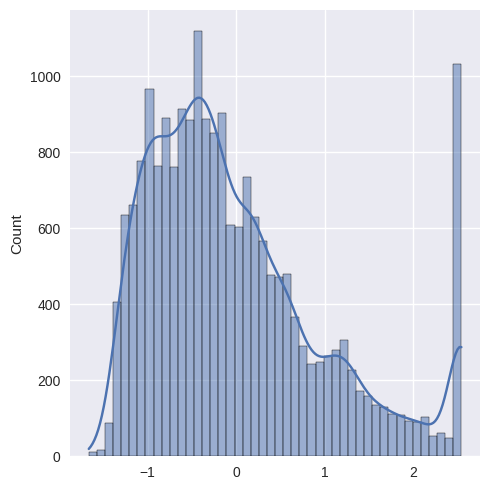

In [5]:
val = df.median_house_value.values 
scale = (val-val.mean())/val.std()

sns.displot(scale,kde=True)

In [6]:
columns = ['latitude', 'longitude','housing_median_age','total_rooms',
'total_bedrooms','population','households','median_income','median_house_value']
len(columns)

9

## Q1. Find a feature with missing values. How many missing values does it have?

In [7]:
missing = df[columns].isnull().sum()
cols_missing = missing[missing>0]
print(cols_missing)

total_bedrooms    207
dtype: int64


## Q2. Whats the median for "population"

In [8]:
median_population = df.population.median()
print(f"The median for the variable population is {median_population}")

The median for the variable population is 1166.0


# Split dataset

In [9]:
idxs = df.index.values 
np.random.seed(42)
np.random.shuffle(idxs)

df_new = df.iloc[idxs][columns].copy()



In [10]:
n = len(df_new)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - (n_val+n_test)

In [11]:
df_train = df_new.iloc[idxs[:n_train]].reset_index(drop=True)
df_val = df_new.iloc[idxs[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df_new.iloc[idxs[n_train+n_val:]].reset_index(drop=True)

In [12]:
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

In [13]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## Q3 

- We need to deal with missing values for the column from Q1
- We have two options: fill it with 0 or with the mean of this variable.

In [14]:
mean = df_train['total_bedrooms'].mean() # mean from training data

df_train_mean = df_train.copy()
df_train_zero = df_train.copy()
df_train_mean['total_bedrooms'] = df_train_mean['total_bedrooms'].fillna(mean)
df_train_zero['total_bedrooms'] = df_train_zero['total_bedrooms'].fillna(0.0)

df_val_mean = df_val.copy()
df_val_zero = df_val.copy()
df_val_mean['total_bedrooms'] = df_val_mean['total_bedrooms'].fillna(mean)
df_val_zero['total_bedrooms'] = df_val_zero['total_bedrooms'].fillna(0.0)

In [15]:
X_train_mean = df_train_mean.values 
X_train_zero = df_train_zero.values

X_val_mean = df_val_mean.values 
X_val_zero = df_val_zero.values

Now, we try both options. For each, train a linear regression model without regularization using the code from the lessons.

In [16]:
Xs_train = [X_train_mean,X_train_zero]
Xs_val = [X_val_mean,X_val_zero]
scores = []
for i,X_train in enumerate(Xs_train):
    w0,w = train_linear_regression(X_train,y_train)
    y_pred = Xs_val[0].dot(w) + w0 
    
    # Calculate and store RMSE
    score = rmse(y_preds=y_pred,y=y_val)
    scores.append(np.round(score,2))

scores
    

[0.34, 0.34]

## Q4

In [17]:
def prepare_X(df):
    df = df.copy()
    
    #Fill NaNs with 0.0 
    df.fillna(0.0,inplace=True)
    
    X = df.values 
    return X

In [18]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

Now, we evaluate the effect of different regularization values $\alpha$

In [19]:
alphas = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
scores = {}
for alpha in alphas:
    
    w0,w = train_linear_regression_reg(X_train,y_train,alpha=alpha)
    # Validation
    y_val_pred = X_val.dot(w) + w0

    scores.update({str(alpha):np.round(rmse(y_preds=y_val_pred,y=y_val),2)})

print(scores)

best_param = min(scores,key=scores.get)

print(f"The best alpha is {best_param} with a score of {scores[best_param]}")


{'0': 0.34, '1e-06': 0.34, '0.0001': 0.34, '0.001': 0.34, '0.01': 0.34, '0.1': 0.34, '1': 0.35, '5': 0.35, '10': 0.35}
The best alpha is 0 with a score of 0.34


## Q5 

Now, we want to evaluate what is the effect of the random seed we use when we split the dataset into training ,validation an test. This will allow to understand how stable or unstable or model is.

In [20]:
idxs = df.index.values

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for i,seed in enumerate(seeds):
    (df_train,y_train),(df_val,y_val),(df_test,y_test) = split_dataset(df[columns],val_size=0.2,test_size=0.2,seed=seed)
    X_train = prepare_X(df_train)
    X_val = prepare_X(df_val)
    
    w0,w = train_linear_regression(X_train,y_train)
    # Validation
    y_val_pred = X_val.dot(w) + w0

    scores.append(rmse(y_preds=y_val_pred,y=y_val))

scores = np.array(scores)

np.round(np.std(scores),3)



0.005

## Q6 

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [21]:
seed = 9 # Random seed
alpha = 0.001 # Regularization

# Dataset split
(df_train,y_train),(df_val,y_val),(df_test,y_test) = split_dataset(df[columns],val_size=0.2,test_size=0.2,seed=seed)

# Merge training and validtion dataset
df_full_train = pd.concat([df_train,df_val]).reset_index(drop=True)
y_full_train = np.concatenate([y_train,y_val])

# Fill NaNs and return Features (X) arrays

X_full_train = prepare_X(df_full_train)
X_test = prepare_X(df_test)

#Train regularized linear regression

w0,w = train_linear_regression_reg(X_full_train,y_full_train,alpha=alpha)

# Predict
y_test_pred = X_test.dot(w) + w0

#Evaluate
score = np.round(rmse(y_preds=y_test_pred,y=y_test),2)
print(score)

0.34
